Imports

In [94]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD, PCA
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state

In [95]:
train_df = pd.read_csv("../data/raw/claims_raw_train.csv")
test_df = pd.read_csv("../data/raw/claims_raw_test.csv")
train_df["ClaimRate"] = train_df["ClaimNb"] / train_df["Exposure"]
train_df.drop(["IDpol", "ClaimNb", "Exposure"], axis=1, inplace=True)
test_df["ClaimRate"] = test_df["ClaimNb"] / test_df["Exposure"]
test_df.drop(["IDpol", "ClaimNb", "Exposure"], axis=1, inplace=True)
target = "ClaimRate"
y_train = train_df.drop([target], inplace=True, axis=1)
y_test = test_df.drop([target], inplace=True, axis=1)

In [96]:
def ohe(train_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    cat_cols = train_df.select_dtypes(include=["object", "category", "string", "bool"]).columns.tolist()
    num_cols = [c for c in train_df.columns if c not in cat_cols]
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")),
                ("scale", StandardScaler())
            ]), num_cols),
            ("cat", OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=True,
                dtype=np.float32
            ), cat_cols),
        ],
        remainder="drop"
    )
        
    preprocessor.fit(train_df)
    Xtr_enc = preprocessor.transform(train_df)
    Xte_enc = preprocessor.transform(test_df)
    
    
    
    return Xtr_enc, Xte_enc


In [97]:
def elbow_on_train(X_train: int, randomized: bool, seed: int, target: float):
    reducer = TruncatedSVD(
        n_components=X_train.shape[1]-1,
        algorithm="randomized",
        n_iter=7 if randomized else 0,
        random_state=seed
    )
    
    reducer.fit(X_train)
    evr = reducer.explained_variance_ratio_
    cum = np.cumsum(evr)
    
    plt.figure()
    plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
    plt.xlabel("k components")
    plt.ylabel("Cumulative explained variance")
    plt.title(("TruncatedSVD") + " Elbow (train only)")
    plt.grid(True)
    plt.show()

    return reducer, evr, cum, int(np.searchsorted(cum, target) + 1)

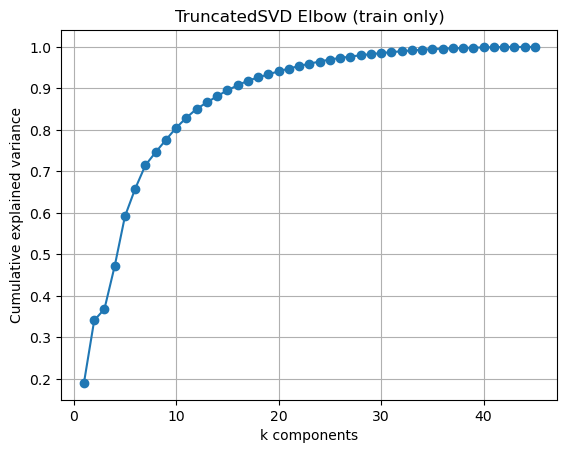

Z_train shape: (542410, 16) Z_test shape: (135603, 16)
Cumulative variance kept: 0.9074801232704655


In [98]:
X_train, X_test = ohe(train_df, test_df)
probe, evr, cum, k = elbow_on_train(X_train, True, 42, 0.9)
reducer = TruncatedSVD(n_components=k, algorithm="randomized", n_iter=7, random_state=42)
reducer.fit(X_train)

Z_train = reducer.transform(X_train)
Z_test = reducer.transform(X_test)

evr_final = reducer.explained_variance_ratio_

evr_final = reducer.explained_variance_ratio_
print("Z_train shape:", Z_train.shape, "Z_test shape:", Z_test.shape)
print("Cumulative variance kept:", float(np.cumsum(evr_final)[-1]))

In [99]:
def plot_2d_projection(X, y, title="2D projection", random_state=42):
    # Use SVD(2) so it works for sparse or dense
    proj = TruncatedSVD(n_components=2, random_state=random_state).fit_transform(X)

    plt.figure()
    sc = plt.scatter(proj[:,0], proj[:,1], c=y, s=7, alpha=0.7)
    plt.colorbar(sc, label="target")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True, alpha=0.3)
    plt.show()

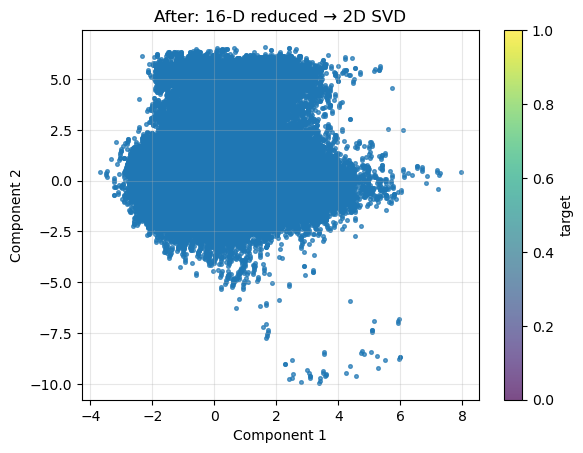

In [100]:
plot_2d_projection(Z_train, y_train, title=f"After: {k}-D reduced → 2D SVD")


Clustering

In [101]:
def subsample_rows(X, y=None, n=20000, seed=42):
    n = min(n, X.shape[0])
    rng = check_random_state(seed)
    idx = rng.choice(X.shape[0], size=n, replace=False)
    Xs = X[idx] if sparse.isspmatrix(X) else X[idx, :]
    ys = None if y is None else np.asarray(y)[idx]
    return Xs, ys, idx

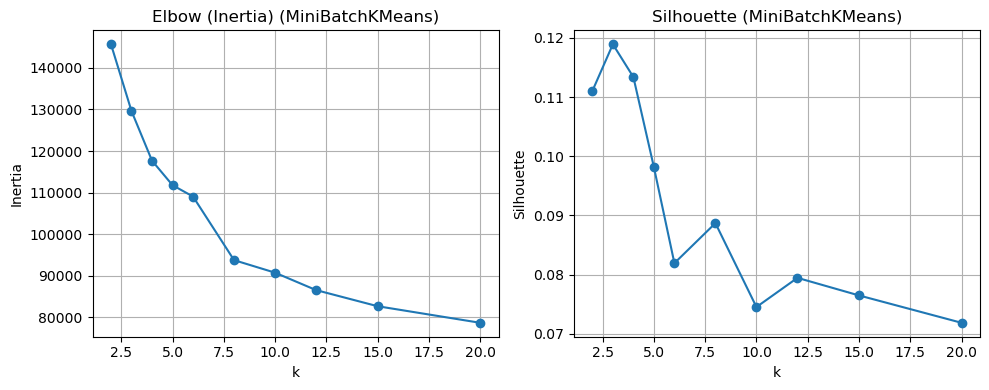

In [102]:

def k_sweep_minibatch_kmeans(X, k_list, sample_n=20000, seed=42, batch_size=2048, max_iter=100):
    Xs, _, _ = subsample_rows(X, n=sample_n, seed=seed)
    inertias, sils = [], []
    for k in k_list:
        km = MiniBatchKMeans(
            n_clusters=k,
            init="k-means++",
            random_state=seed,
            batch_size=batch_size,
            max_iter=max_iter,
            n_init="auto"
        )
        km.fit(Xs)
        inertias.append(km.inertia_)
        # Silhouette is O(n^2); use small subsample internally if Xs is still big
        try:
            sil = silhouette_score(Xs, km.predict(Xs), metric="euclidean", sample_size=min(8000, Xs.shape[0]), random_state=seed)
        except Exception:
            sil = np.nan
        sils.append(sil)
    return inertias, sils

def plot_k_selection(k_list, inertias, sils, title_suffix=""):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(k_list, inertias, marker="o")
    ax[0].set_title(f"Elbow (Inertia) {title_suffix}")
    ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia"); ax[0].grid(True)
    ax[1].plot(k_list, sils, marker="o")
    ax[1].set_title(f"Silhouette {title_suffix}")
    ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette"); ax[1].grid(True)
    plt.tight_layout(); plt.show()

svd, Z_train = reducer, Z_train
X_for_cluster = Z_train

k_list = [2,3,4,5,6,8,10,12,15,20]
inertias, sils = k_sweep_minibatch_kmeans(X_train, k_list)
plot_k_selection(k_list, inertias, sils, title_suffix="(MiniBatchKMeans)")


In [107]:
K_FINAL = 10

kmeans = MiniBatchKMeans(
    n_clusters=K_FINAL,
    init="k-means++",
    random_state=42,
    batch_size=4096,
    max_iter=200,
    n_init="auto"
)
kmeans.fit(X_for_cluster)  # full train representation

# Predict labels
if 'Z_train' in globals():
    # Option B
    y_cluster_train = kmeans.predict(Z_train)
    y_cluster_test  = kmeans.predict(svd.transform(X_test))
else:
    # Option A
    y_cluster_train = kmeans.predict(X_train)
    y_cluster_test  = kmeans.predict(X_test)

# Quick cluster sizes
(unique, counts) = np.unique(y_cluster_train, return_counts=True)
print("Cluster sizes (train):", dict(zip(unique, counts)))


Cluster sizes (train): {np.int32(0): np.int64(80750), np.int32(1): np.int64(77014), np.int32(2): np.int64(46832), np.int32(3): np.int64(64130), np.int32(4): np.int64(35204), np.int32(5): np.int64(54790), np.int32(6): np.int64(56281), np.int32(7): np.int64(12140), np.int32(8): np.int64(65237), np.int32(9): np.int64(50032)}


In [108]:
# Evaluate in the SAME space used to fit k-means (X_for_cluster)
Xs_eval, _, idx_eval = subsample_rows(X_for_cluster, n=20000, seed=42)
labels_eval = kmeans.predict(Xs_eval)

sil = silhouette_score(Xs_eval, labels_eval, metric="euclidean", sample_size=min(10000, Xs_eval.shape[0]), random_state=42)
ch  = calinski_harabasz_score(Xs_eval, labels_eval)
db  = davies_bouldin_score(Xs_eval, labels_eval)

print(f"Silhouette: {sil:.4f} (↑ better)")
print(f"Calinski-Harabasz: {ch:.1f} (↑ better)")
print(f"Davies-Bouldin: {db:.4f} (↓ better)")


Silhouette: 0.1018 (↑ better)
Calinski-Harabasz: 2079.8 (↑ better)
Davies-Bouldin: 2.0020 (↓ better)


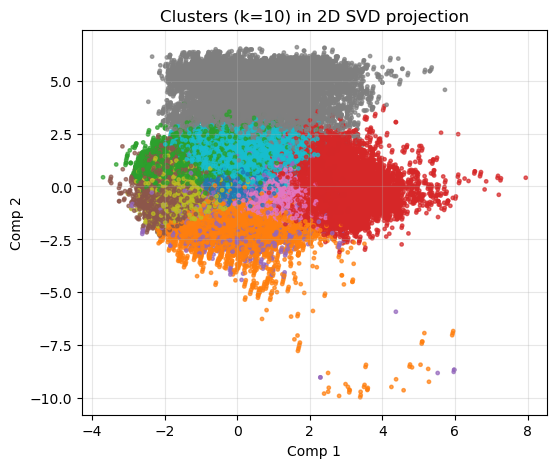

In [109]:
if 'Z_train' in globals():
    # Already dense low-dim → just 2D with SVD for visualization
    Viz2 = TruncatedSVD(n_components=2, random_state=42).fit_transform(Z_train)
else:
    Viz2 = TruncatedSVD(n_components=2, random_state=42).fit_transform(X_train)

labels_plot = y_cluster_train

plt.figure(figsize=(6,5))
plt.scatter(Viz2[:,0], Viz2[:,1], c=labels_plot, s=6, alpha=0.7, cmap="tab10")
plt.title(f"Clusters (k={K_FINAL}) in 2D SVD projection")
plt.xlabel("Comp 1"); plt.ylabel("Comp 2"); plt.grid(True, alpha=0.3)
plt.show()

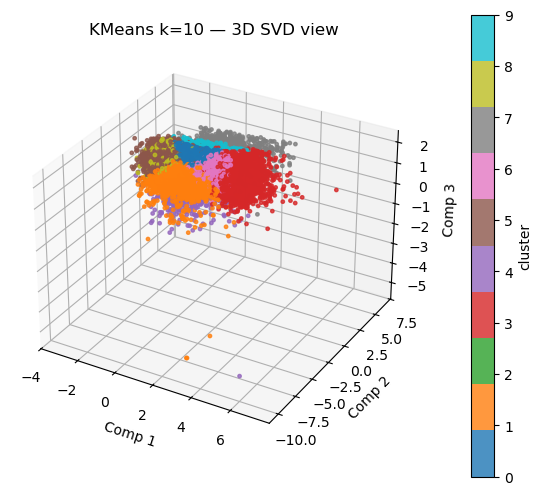

In [110]:
def plot_clusters_3d(X_repr, labels, title="Clusters in 3D (SVD projection)", sample_n=30000, seed=42):
    """
    X_repr: the representation you clustered on (Z_train for Option B, or X_train for Option A)
    labels: cluster labels for those rows (same order/length as X_repr)
    """
    # downsample for speed/clarity on big sets
    rng = np.random.RandomState(seed)
    n = min(sample_n, X_repr.shape[0])
    idx = rng.choice(X_repr.shape[0], size=n, replace=False)

    # 3D projection (SVD works for both sparse/dense)
    svd3 = TruncatedSVD(n_components=3, random_state=seed)
    P = svd3.fit_transform(X_repr[idx])

    # 3D plot
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")
    sc = ax.scatter(P[:,0], P[:,1], P[:,2], c=np.asarray(labels)[idx], s=6, alpha=0.8, cmap="tab10")
    ax.set_xlabel("Comp 1"); ax.set_ylabel("Comp 2"); ax.set_zlabel("Comp 3")
    ax.set_title(title)
    fig.colorbar(sc, ax=ax, pad=0.1, label="cluster")
    plt.show()

X_repr = Z_train; labels = y_cluster_train
# If you clustered directly on OHE (Option A): X_repr = X_train; labels = y_cluster_train
plot_clusters_3d(Z_train, y_cluster_train, title=f"KMeans k={K_FINAL} — 3D SVD view")
